In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #transforms.ToPILImage(),
                                      #transforms.Resize((28, 28)),
                                      #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomRotation((-7.0, 7.0), fill=(0.13,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       #transforms.RandomRotation((-5.0, 5.0), fill=(-0.42,)),
                                       transforms.RandomAffine((-5,5), translate=None, scale=None, shear=5, resample=False, fillcolor=(-0.42,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

#dict to store model loss and accuracy parameters
history = {}

CUDA Available? True


In [ ]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_decay > 0:
      l1_loss = 0
      for param in model.parameters():
        l1_loss += torch.norm(param,1)
      loss += l1_decay * l1_loss
    if l2_decay > 0:
      l2_loss = 0
      for param in model.parameters():
        l2_loss += torch.norm(param,2)
      loss += l2_decay * l2_loss
    train_loss_list.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar_str = f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}'
    if l1_decay > 0:
      pbar_str = f'L1_loss={l1_loss.item()} %s' % (pbar_str)
    if l2_decay > 0:
      pbar_str = f'L2_loss={l2_loss.item()} %s' % (pbar_str)

    pbar.set_description(desc= pbar_str)
    train_accuracy_list.append(100*correct/processed)
  
  print("length of Average loss {}, length of Average accuracy {}".format(len(train_loss_list),len(train_accuracy_list)))
  return train_loss_list, train_accuracy_list


def test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, is_last_epoch):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            is_correct = pred.eq(target.view_as(pred))
            if is_last_epoch:
              misclassified_inds = (is_correct==0).nonzero()[:,0]
              for mis_ind in misclassified_inds:
                if len(misclassified_imgs) == 100: #handtune this for images we need
                  break
                misclassified_imgs.append({
                    "target": target[mis_ind].cpu().numpy(),
                    "pred": pred[mis_ind][0].cpu().numpy(),
                    "img": data[mis_ind].cpu().numpy()[0]
                })
            correct += is_correct.sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    print('Test set: Average loss: {:.6f}, Average accuracy: {}/{} ({:.6f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        test_accuracy))
    
    return test_loss_list, test_accuracy_list, misclassified_imgs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [30, 12]

def training_curves(history):
  plt.figure(1)
  plt.suptitle("Combined Training Curves", fontsize=28)

  plt.subplot(2,2, 1)
  for i in history:
    plt.plot(np.array(history[i]['train_loss']), label=i)
  #plt.plot(np.array(hist_train_acc), 'r')
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training loss per batch")

  plt.subplot(2,2, 2)
  for i in history:
    plt.plot(np.array(history[i]['test_loss']), label=i)
  plt.ylim(ymin=0)
  plt.ylabel('loss')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test loss per epoch")

  plt.subplot(2,2, 3)
  for i in history:
    plt.plot(np.array(history[i]['train_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Training accuracy per batch")

  plt.subplot(2,2, 4)
  for i in history:
    plt.plot(np.array(history[i]['test_accuracy']), label=i)
  plt.ylim(top=100)
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.minorticks_on()
  plt.grid()
  plt.legend()
  plt.title("Test accuracy per epoch")


### These functions will go to Utils

In [ ]:
def Gen_BN(out_features, channel_size, norm_type):
  if norm_type=="BN":
    m = nn.BatchNorm2d(out_features)
  elif norm_type == "LN":
    # x = torch.rand(2,out_features,channel_size,channel_size)
    # m = nn.LayerNorm(x.size()[1:])
    m = nn.LayerNorm((out_features, channel_size, channel_size))
  return m

def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    """
    Utility function for computing output of convolutions
    takes a tuple of (h,w) and returns a tuple of (h,w)
    """
    
    if type(h_w) is not tuple:
        h_w = (h_w, h_w)
    
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    
    if type(stride) is not tuple:
        stride = (stride, stride)
    
    if type(pad) is not tuple:
        pad = (pad, pad)
    
    h = (h_w[0] + (2 * pad[0]) - (dilation * (kernel_size[0] - 1)) - 1)// stride[0] + 1
    w = (h_w[1] + (2 * pad[1]) - (dilation * (kernel_size[1] - 1)) - 1)// stride[1] + 1
    
    return h, w

x, y = conv_output_shape(28, 3, 1,0,1)
x, y
temp = Gen_BN(12, 28, "LN")
temp

LayerNorm((12, 28, 28), eps=1e-05, elementwise_affine=True)

This class will take in the optin of which normalization we would want to use.. 

Group normalization is pending


Input to the architecture is the nrmalization type and input image size

In [ ]:
dropout_value = 0.05


class Net2(nn.Module):
    def get_bn(self, out_features, channel_size, norm_type, num_groups):
        if norm_type=="BN":
          m = nn.BatchNorm2d(out_features)
        elif norm_type == "LN":
          m = nn.LayerNorm((out_features, channel_size, channel_size))
        elif norm_type == "GN":
          if (out_features % num_groups) != 0:
            print('Error: the number of groups should be divisible by output features')
          else:
            m = nn.GroupNorm(num_groups, out_features)
        return m


    def conv_block(self, in_features, out_features, kernel_size, input_channel_size, Norm_type, num_groups, pading=0, last_block=True):
      # convolution
      layers = []
      layers = [nn.Conv2d(in_features, out_features, kernel_size, padding=pading, bias=False), nn.ReLU()]
      out_img_size, _ = conv_output_shape(input_channel_size, kernel_size, stride=1,pad=pading,dilation=1) # get the image size after convolution

      #Generate Normalization
      norm_list = ['BN', 'LN', 'GN'] # this is the list of normalization that is allowed. 
      if (Norm_type in norm_list) and (kernel_size != 1) and (last_block):   # Check if normalization is in the list, or if its not 1x1 or if its not last block. 
        BN = self.get_bn(out_features, out_img_size, Norm_type, num_groups)
        layers.append(BN)

      # Add Dropout - Check if its not last block or 1x1 convolution.   
      if kernel_size !=1 and last_block :
        layers.append(nn.Dropout(dropout_value))
      block = nn.Sequential(*layers)
      return block, out_img_size

    def max_pool_block(self, kernal_size, stride, img_size):
        pool = nn.MaxPool2d(kernal_size, stride) # output_size = 13
        out_img_size,_ = conv_output_shape(img_size,kernal_size, stride)
        return pool, out_img_size

    def __init__(self, Norm_type="", input_img_size=(1,28,28), num_groups=2):
        super(Net2, self).__init__()
        self.convblock1, img_size = self.conv_block(1,8,3,input_img_size[1],Norm_type,num_groups) # input kernal, output_kernals, convolution, input image size, padding, normalization type #26
        self.convblock2, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #24
        self.pool1, img_size = self.max_pool_block(2,2, img_size)  #12
        self.convblock4, img_size = self.conv_block(16,8,1,img_size,Norm_type,num_groups) #12
        self.convblock5, img_size = self.conv_block(8,16,3,img_size,Norm_type,num_groups) #10
        self.convblock6, img_size = self.conv_block(16,20,3,img_size,Norm_type,num_groups) #8
        self.convblock7, img_size = self.conv_block(20,8,1,img_size,Norm_type,num_groups) #8
        self.convblock8, img_size = self.conv_block(8,16,3,img_size,Norm_type, num_groups, last_block=False) #6

        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=6)) # output_size = 1
        self.fc1 = nn.Linear(16, 10)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        #x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

temp = Net2("BN", input_img_size=(1, 28, 28), num_groups=2).to(device)
summary(temp, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
             ReLU-11            [-1, 8, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,152
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1, 16,

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0
l2_decay=0.0
norm_type = "BN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.017963647842407227 Batch_id=937 Accuracy=88.37: 100%|██████████| 938/938 [00:04<00:00, 194.39it/s]


length of Average loss 938, length of Average accuracy 938

learning rate 0.1


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.072770, Average accuracy: 9769/10000 (97.690000%)

EPOCH: 2


Loss=0.09612488001585007 Batch_id=937 Accuracy=96.96: 100%|██████████| 938/938 [00:04<00:00, 191.62it/s]

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.061054, Average accuracy: 9815/10000 (98.150000%)

EPOCH: 3


Loss=0.026722867041826248 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [00:04<00:00, 197.75it/s]

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.033115, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 4


Loss=0.002310727024450898 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:04<00:00, 194.10it/s]

length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.032592, Average accuracy: 9892/10000 (98.920000%)

EPOCH: 5


Loss=0.0017881314270198345 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:04<00:00, 191.08it/s]

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031847, Average accuracy: 9893/10000 (98.930000%)

EPOCH: 6


Loss=0.10997962951660156 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:04<00:00, 194.60it/s]

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031231, Average accuracy: 9896/10000 (98.960000%)

EPOCH: 7


Loss=0.0020459445659071207 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:04<00:00, 192.68it/s]

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.030958, Average accuracy: 9900/10000 (99.000000%)

EPOCH: 8


Loss=0.11211088299751282 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:04<00:00, 193.74it/s]

length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031405, Average accuracy: 9895/10000 (98.950000%)

EPOCH: 9


Loss=0.045140430331230164 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:04<00:00, 196.78it/s]

length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031130, Average accuracy: 9896/10000 (98.960000%)

EPOCH: 10


Loss=0.11198841780424118 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:04<00:00, 193.08it/s]

length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031065, Average accuracy: 9896/10000 (98.960000%)

EPOCH: 11


Loss=0.16900430619716644 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:04<00:00, 192.17it/s]

length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031156, Average accuracy: 9897/10000 (98.970000%)

EPOCH: 12


Loss=0.0009414731175638735 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:04<00:00, 191.89it/s]

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031043, Average accuracy: 9897/10000 (98.970000%)

EPOCH: 13


Loss=0.01111788209527731 Batch_id=937 Accuracy=98.74: 100%|██████████| 938/938 [00:04<00:00, 194.19it/s]

length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031045, Average accuracy: 9894/10000 (98.940000%)

EPOCH: 14


Loss=0.022759435698390007 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:04<00:00, 197.55it/s]

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.030874, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 15


Loss=0.004223130643367767 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:04<00:00, 196.24it/s]

length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031012, Average accuracy: 9896/10000 (98.960000%)

EPOCH: 16


Loss=0.013409849256277084 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:04<00:00, 196.10it/s]

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031080, Average accuracy: 9897/10000 (98.970000%)

EPOCH: 17


Loss=0.0014677823055535555 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:04<00:00, 192.56it/s]

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.030906, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 18


Loss=0.01775186136364937 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [00:04<00:00, 191.19it/s]

length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031167, Average accuracy: 9897/10000 (98.970000%)

EPOCH: 19


Loss=0.0422225184738636 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [00:04<00:00, 195.60it/s]

length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.031005, Average accuracy: 9897/10000 (98.970000%)

EPOCH: 20


Loss=0.06088469922542572 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:04<00:00, 194.64it/s]

length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0


Test set: Average loss: 0.031267, Average accuracy: 9899/10000 (98.990000%)



In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0
l2_decay=0.0
norm_type = "LN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.08309382945299149 Batch_id=937 Accuracy=86.76: 100%|██████████| 938/938 [00:04<00:00, 188.87it/s]

length of Average loss 938, length of Average accuracy 938

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.116597, Average accuracy: 9638/10000 (96.380000%)

EPOCH: 2


Loss=0.14784419536590576 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [00:04<00:00, 196.04it/s]

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.060733, Average accuracy: 9808/10000 (98.080000%)

EPOCH: 3


Loss=0.0032923095859587193 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:04<00:00, 194.94it/s]

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.036178, Average accuracy: 9887/10000 (98.870000%)

EPOCH: 4


Loss=0.003296667244285345 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:04<00:00, 196.09it/s]

length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.037370, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 5


Loss=0.0017954730428755283 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:04<00:00, 192.95it/s]

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034766, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 6


Loss=0.00383091252297163 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:04<00:00, 192.86it/s]

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034258, Average accuracy: 9900/10000 (99.000000%)

EPOCH: 7


Loss=0.008845990523695946 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:04<00:00, 199.15it/s]

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034279, Average accuracy: 9900/10000 (99.000000%)

EPOCH: 8


Loss=0.03556538000702858 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:04<00:00, 197.34it/s]

length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034270, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 9


Loss=0.0036724237725138664 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:04<00:00, 195.32it/s]

length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 10


Loss=0.014935659244656563 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [00:04<00:00, 196.67it/s]


length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034273, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 11


Loss=0.10590965300798416 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:04<00:00, 195.41it/s]

length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034273, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 12


Loss=0.22516025602817535 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:04<00:00, 193.60it/s]

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 13


Loss=0.036543894559144974 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [00:04<00:00, 191.27it/s]


length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 14


Loss=0.0013337678974494338 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:04<00:00, 197.67it/s]

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 15


Loss=0.002256285399198532 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:04<00:00, 195.77it/s]


length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 16


Loss=0.006617135833948851 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:04<00:00, 194.68it/s]

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 17


Loss=0.0010933458106592298 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:04<00:00, 194.66it/s]

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 18


Loss=0.008402557112276554 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [00:04<00:00, 196.17it/s]

length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 19


Loss=0.004635956604033709 Batch_id=937 Accuracy=98.69: 100%|██████████| 938/938 [00:04<00:00, 193.03it/s]


length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)

EPOCH: 20


Loss=0.10585110634565353 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [00:04<00:00, 195.72it/s]


length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0
Test set: Average loss: 0.034274, Average accuracy: 9899/10000 (98.990000%)



In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import ExponentialLR
from torch.optim.lr_scheduler import StepLR

# Input parameters for the model
EPOCHS = 20
l1_decay=0.0
l2_decay=0.0
norm_type = "GN"
num_groups=2
input_img_size=(1, 28, 28)


# Run model
model = Net2(norm_type, input_img_size, num_groups).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# run_model(model, optimizer, scheduler, EPOCHS, l1=0.0, l2=0.0)

train_loss_list = []
train_accuracy_list = []
test_loss_list = []
test_accuracy_list = []
misclassified_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_loss_list, train_accuracy_list = train(model, device, train_loader, optimizer, epoch, l1_decay, l2_decay, train_loss_list, train_accuracy_list)
    print("\nlearning rate", np.round(optimizer.param_groups[0]['lr'],4))
    scheduler.step()
    # test(model1, device, test_loader, test_losses, test_acc, misclassified_imgs, epoch==EPOCHS-1)
    test_loss_list, test_accuracy_list, misclassified_imgs = test(model, device, test_loader, test_loss_list, test_accuracy_list, misclassified_imgs, epoch==EPOCHS-1)

name = norm_type + '_model'
history[name] = {}
history[name]['train_loss'] = train_loss_list
history[name]['train_accuracy'] = train_accuracy_list
history[name]['test_loss'] = test_loss_list
history[name]['test_accuracy'] = test_accuracy_list
history[name]['misclassified_imgs'] = misclassified_imgs

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.00853944756090641 Batch_id=937 Accuracy=84.88: 100%|██████████| 938/938 [00:04<00:00, 194.33it/s]

length of Average loss 938, length of Average accuracy 938

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.105178, Average accuracy: 9682/10000 (96.820000%)

EPOCH: 2


Loss=0.09272133558988571 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [00:04<00:00, 197.21it/s]

length of Average loss 1876, length of Average accuracy 1876

learning rate 0.1



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.068923, Average accuracy: 9809/10000 (98.090000%)

EPOCH: 3


Loss=0.18997834622859955 Batch_id=937 Accuracy=98.22: 100%|██████████| 938/938 [00:04<00:00, 199.49it/s]

length of Average loss 2814, length of Average accuracy 2814

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.042715, Average accuracy: 9871/10000 (98.710000%)

EPOCH: 4


Loss=0.06895807385444641 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:04<00:00, 196.38it/s]

length of Average loss 3752, length of Average accuracy 3752

learning rate 0.01



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.041695, Average accuracy: 9876/10000 (98.760000%)

EPOCH: 5


Loss=0.0030438306275755167 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:04<00:00, 195.97it/s]

length of Average loss 4690, length of Average accuracy 4690

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039829, Average accuracy: 9880/10000 (98.800000%)

EPOCH: 6


Loss=0.015524247661232948 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [00:04<00:00, 197.27it/s]

length of Average loss 5628, length of Average accuracy 5628

learning rate 0.001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039425, Average accuracy: 9884/10000 (98.840000%)

EPOCH: 7


Loss=0.029308222234249115 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:04<00:00, 200.66it/s]

length of Average loss 6566, length of Average accuracy 6566

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039401, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 8


Loss=0.07600964605808258 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:04<00:00, 190.81it/s]

length of Average loss 7504, length of Average accuracy 7504

learning rate 0.0001



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039505, Average accuracy: 9884/10000 (98.840000%)

EPOCH: 9


Loss=0.004911221098154783 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:04<00:00, 192.67it/s]

length of Average loss 8442, length of Average accuracy 8442

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039496, Average accuracy: 9884/10000 (98.840000%)

EPOCH: 10


Loss=0.009383449330925941 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:04<00:00, 194.69it/s]

length of Average loss 9380, length of Average accuracy 9380

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039483, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 11


Loss=0.09951569139957428 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:04<00:00, 196.50it/s]


length of Average loss 10318, length of Average accuracy 10318

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039482, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 12


Loss=0.02110365964472294 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:04<00:00, 197.67it/s]

length of Average loss 11256, length of Average accuracy 11256

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 13


Loss=0.07416804879903793 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 195.12it/s]

length of Average loss 12194, length of Average accuracy 12194

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 14


Loss=0.004231469705700874 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:04<00:00, 191.79it/s]

length of Average loss 13132, length of Average accuracy 13132

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 15


Loss=0.02505807764828205 Batch_id=937 Accuracy=98.51: 100%|██████████| 938/938 [00:04<00:00, 195.01it/s]


length of Average loss 14070, length of Average accuracy 14070

learning rate 0.0


  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 16


Loss=0.010590503923594952 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:04<00:00, 199.76it/s]

length of Average loss 15008, length of Average accuracy 15008

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 17


Loss=0.007325761951506138 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:04<00:00, 193.20it/s]

length of Average loss 15946, length of Average accuracy 15946

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 18


Loss=0.19199970364570618 Batch_id=937 Accuracy=98.54: 100%|██████████| 938/938 [00:04<00:00, 195.75it/s]

length of Average loss 16884, length of Average accuracy 16884

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 19


Loss=0.0016438363818451762 Batch_id=937 Accuracy=98.59: 100%|██████████| 938/938 [00:04<00:00, 195.30it/s]

length of Average loss 17822, length of Average accuracy 17822

learning rate 0.0



  0%|          | 0/938 [00:00<?, ?it/s]

Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)

EPOCH: 20


Loss=0.09364096820354462 Batch_id=937 Accuracy=98.55: 100%|██████████| 938/938 [00:04<00:00, 197.11it/s]


length of Average loss 18760, length of Average accuracy 18760

learning rate 0.0
Test set: Average loss: 0.039481, Average accuracy: 9885/10000 (98.850000%)



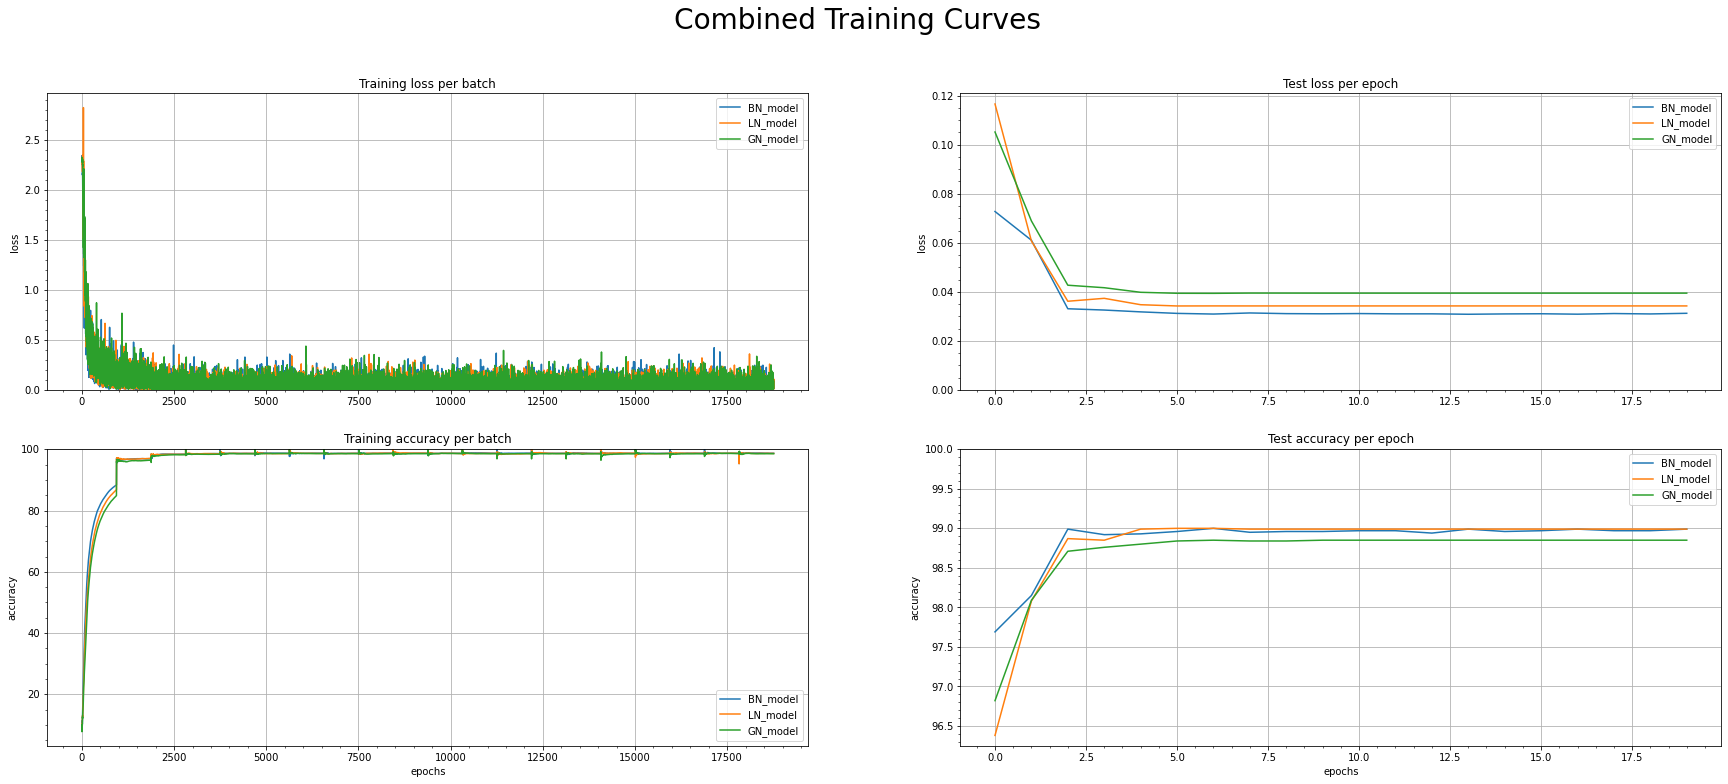

In [ ]:
training_curves(history)

# Check Misclassified Images

In [ ]:
def plot_misclassified_images(img_data, img_name, count):
  figure = plt.figure(figsize=(10, 10))
  num_of_images = len(img_data)
  for index in range(1, count + 1):
      plt.subplot(5, np.ceil(count/5), index)
      plt.axis('off')
      plt.imshow(img_data[index-1]["img"], cmap='gray_r')
      plt.title("Predicted: %s\nActual: %s" % (img_data[index-1]["pred"], img_data[index-1]["target"]))
  plt.tight_layout()
  plt.savefig(img_name)

### L1 + BN model

<ipython-input-71-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


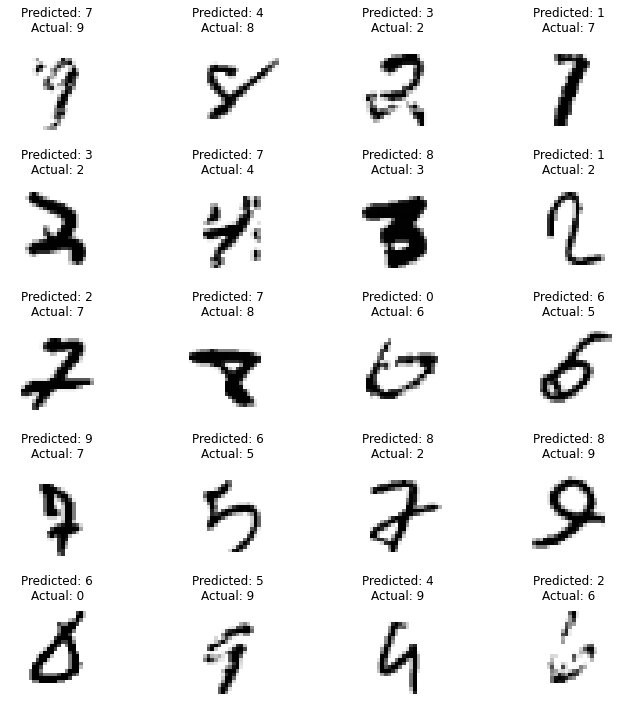

In [ ]:
plot_misclassified_images(history['BN_model']['misclassified_imgs'], "misclassified_imgs_BN.png", 20)

### GN model

<ipython-input-71-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


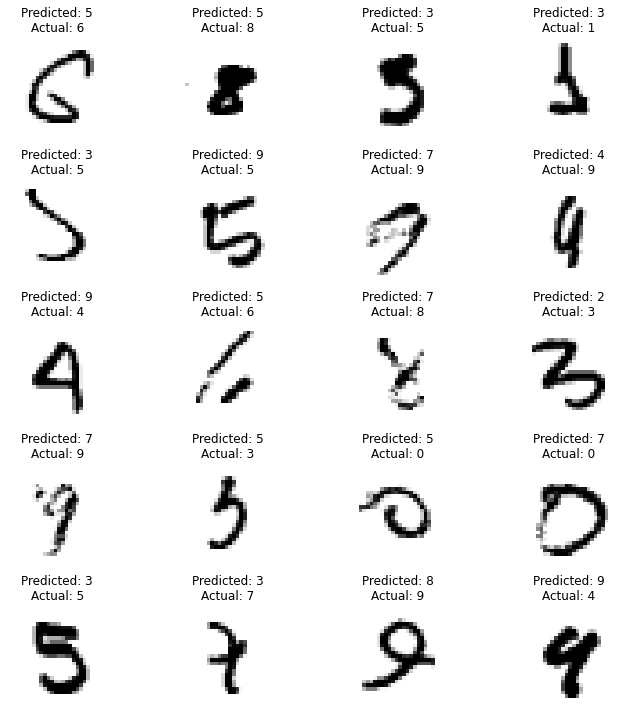

In [ ]:
plot_misclassified_images(history['GN_model']['misclassified_imgs'], "misclassified_imgs_GN.png", 20)

### LN model

<ipython-input-71-bcbfa1a2ba17>:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5, np.ceil(count/5), index)


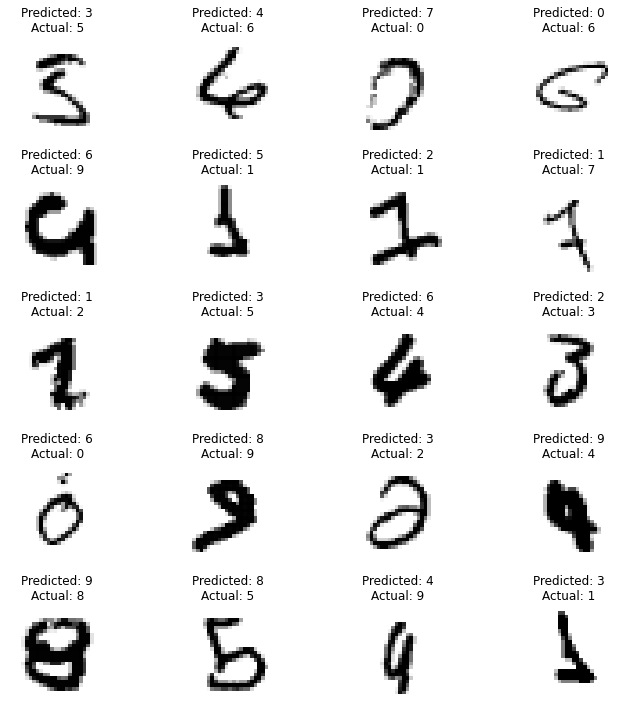

In [ ]:
plot_misclassified_images(history['LN_model']['misclassified_imgs'], "misclassified_imgs_LN.png", 20)